<a href="https://colab.research.google.com/github/soupsoupr/StrokeSegmentation/blob/main/test_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data

In [141]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [142]:
import nibabel as nib
import os
# Set the file path to the directory containing the DWI data files
file_path = '/content/drive/MyDrive/ISLES/dataset-ISLES22^public^unzipped^version'

These two sections are for single case testing

In [143]:
# # load 1 case for testing
# example_case = 30
# # Set images path.
# dwi_path = os.path.join(file_path, 'rawdata', 'sub-strokecase{}'.format("%04d" %example_case), 'ses-0001',
#                         'sub-strokecase{}_ses-0001_dwi.nii.gz'.format("%04d" %example_case))
# mask_path = dwi_path.replace('rawdata', 'derivatives').replace('dwi', 'msk')

# # Load image data.
# dwi_data = []
# mask_data = []

# dwi_data = nib.load(dwi_path).get_fdata()
# mask_data = nib.load(mask_path).get_fdata()

In [144]:
# # Select the slice you want to display from the middle slice
# slice_index = 40

# # Extract the 2D slice from the 3D volume
# slice_dwi_data = dwi_data[:, :, slice_index]
# slice_mask_data = mask_data[:, :, slice_index]
# print(slice_dwi_data.shape)
# print(slice_mask_data.shape)

# # Create a figure and display the top view slice
# plt.figure(figsize=(4, 4))
# plt.imshow(slice_dwi_data, cmap='gray')
# plt.imshow(slice_mask_data, alpha=0.5, cmap='copper')
# plt.title('DWI and Mask Data Visualization')

# # Show the plot
# plt.show()

# Data setup

In [162]:
n = 50  # Number of data sets - there are 250 cases in total
data_list = []  # Initialize an empty list to store the data pairs

for example_case in range(1,n+1): # for the first 10 data from ISLES22
    # Set images path.
    dwi_path = os.path.join(file_path, 'rawdata', 'sub-strokecase{}'.format("%04d" %example_case), 'ses-0001',
                            'sub-strokecase{}_ses-0001_dwi.nii.gz'.format("%04d" %example_case))
    mask_path = dwi_path.replace('rawdata', 'derivatives').replace('dwi', 'msk')

    dwi_data = nib.load(dwi_path).get_fdata()
    mask_data = nib.load(mask_path).get_fdata()

    # Slice from the middle slice
    slice_index = 40

    # Extract the 2D slice from the 3D volume
    slice_dwi_data = dwi_data[:, :, slice_index]
    slice_mask_data = mask_data[:, :, slice_index]

    data_list.append((slice_dwi_data, slice_mask_data))

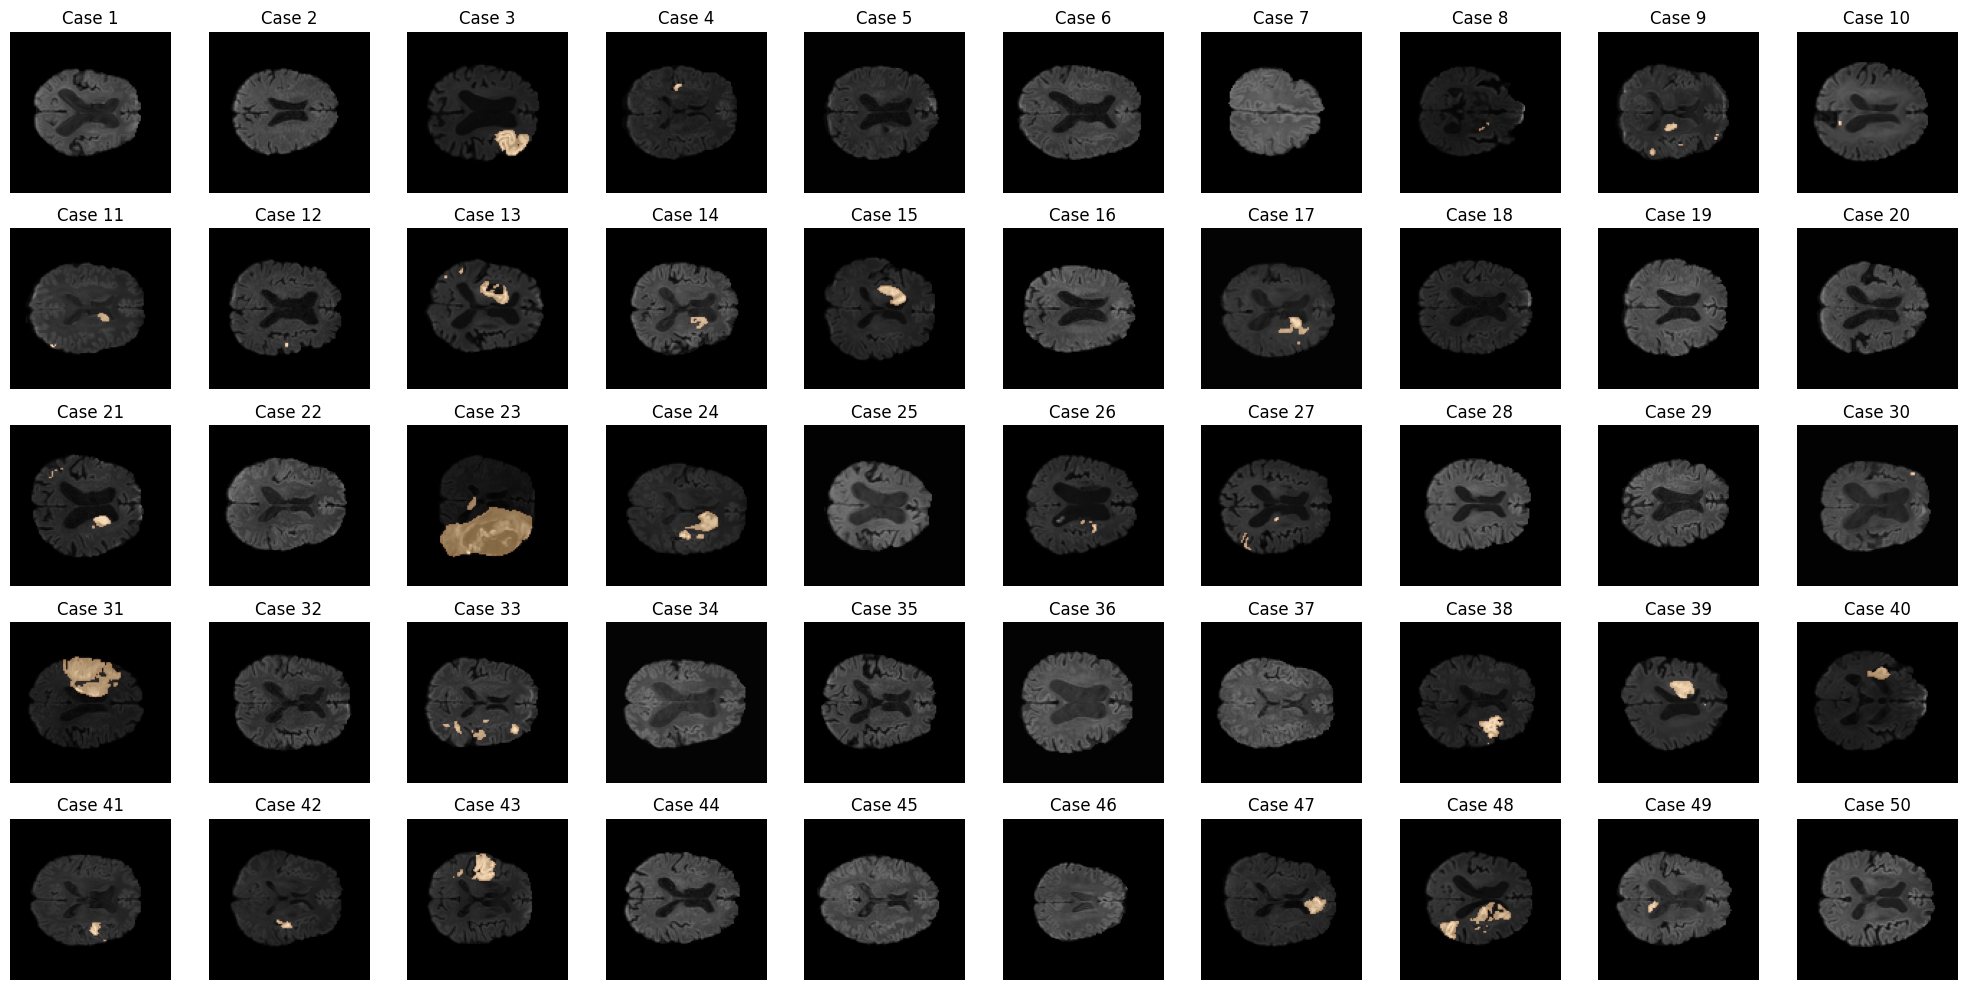

In [163]:
from PIL import Image
from matplotlib import pyplot as plt

# Create a figure with a 5x10 grid of subplots
fig, axes = plt.subplots(5, 10, figsize=(20, 10))

for i, (dwi_data, mask_data) in enumerate(data_list[:50]):
    row = i // 10  # Determine the row index
    col = i % 10   # Determine the column index

    axes[row, col].imshow(dwi_data, cmap='gray') # Plot DWI data
    axes[row, col].imshow(mask_data, alpha=0.5, cmap='copper') # Plot mask data

    axes[row, col].set_title(f'Case {i + 1}')

# Hide axis labels and ticks
for ax in plt.gcf().get_axes():
    ax.axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Import Libraries

In [147]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Split dataset into training and testing sets

In [164]:
from sklearn.model_selection import train_test_split

# separate data into X and y
X = [dwi_data for dwi_data, _ in data_list]  # Assuming DWI data is X
y = [mask_data for _, mask_data in data_list]  # Assuming mask data is y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a custom PyTorch dataset

In [165]:
class CustomDataset(Dataset):
    def __init__ (self, data_list, transformer):
        self.data_list = data_list
        self.transformer = transformer

    def __len__ (self):
        return len(self.data_list)

    def __getitem__ (self, index):
        dwi_data, mask_data = self.data_list[index]
        return dwi_data, mask_data

# Data preprocessing and augmentation

In [166]:
train_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])

test_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])

# Create data loaders

In [167]:
# Train and test sets initalization
train_dataset = CustomDataset(data_list, train_transformer)
test_dataset = CustomDataset(data_list, test_transformer)

In [168]:
# Train and test set data loaders initalization
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

Check data shape
*   shape form [in_channels, height, width]


In [169]:
# Iterate through the data loader
for batch_idx, (image, mask) in enumerate(train_loader):

    print(f'DWI image shape: {image.shape}')
    print(f'Mask shape: {mask.shape}')

    break

DWI image shape: torch.Size([1, 112, 112])
Mask shape: torch.Size([1, 112, 112])


# Define a U-Net architecture for segmentation

## Define the U-Net Model

In [170]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, kernel_size=2, stride=2)
        )

    def forward(self, x):
        # Encoder
        x1 = self.encoder(x)
        # Decoder
        x2 = self.decoder(x1)
        return x2

## Instantiate the U-Net model

In [171]:
in_channels = 1  # DWI images channels
out_channels = 1  # masks channel
model = UNet(in_channels, out_channels)

# Define loss and optimizer

In [172]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop

In [173]:
# Define training parameters
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    # Iterate through the training data in mini-batches
    for i, (dwi_batch, mask_batch) in enumerate(train_loader):
        dwi_batch = dwi_batch.float()  # Convert input data to float32

        # Forward pass
        outputs = model(dwi_batch)

        # Calculate the loss
        loss = criterion(outputs, mask_batch)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print or log training loss for monitoring
        print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

Epoch [1/10], Batch [1/50], Loss: -0.0000
Epoch [1/10], Batch [2/50], Loss: 8.6043
Epoch [1/10], Batch [3/50], Loss: -0.0000
Epoch [1/10], Batch [4/50], Loss: 96.1404
Epoch [1/10], Batch [5/50], Loss: 16.9622
Epoch [1/10], Batch [6/50], Loss: 32.9432
Epoch [1/10], Batch [7/50], Loss: 47.4898
Epoch [1/10], Batch [8/50], Loss: 5.8939
Epoch [1/10], Batch [9/50], Loss: -0.0000
Epoch [1/10], Batch [10/50], Loss: -0.0000
Epoch [1/10], Batch [11/50], Loss: 0.8777
Epoch [1/10], Batch [12/50], Loss: -0.0000
Epoch [1/10], Batch [13/50], Loss: 8.7315
Epoch [1/10], Batch [14/50], Loss: 4.5110
Epoch [1/10], Batch [15/50], Loss: -0.0000
Epoch [1/10], Batch [16/50], Loss: -0.0000
Epoch [1/10], Batch [17/50], Loss: -0.0000
Epoch [1/10], Batch [18/50], Loss: -0.0000
Epoch [1/10], Batch [19/50], Loss: -0.0000
Epoch [1/10], Batch [20/50], Loss: 28.1690
Epoch [1/10], Batch [21/50], Loss: 14.0328
Epoch [1/10], Batch [22/50], Loss: 7.9272
Epoch [1/10], Batch [23/50], Loss: 0.8054
Epoch [1/10], Batch [24/50]

# Evaluation

In [174]:
model.eval()  # Set the model to evaluation mode
total_loss = 0.0

# Initialize variables for evaluation metrics (e.g., accuracy, precision, recall)
correct_predictions = 0
total_predictions = 0

# Evaluation loop
with torch.no_grad():
    for i, (dwi_batch_eval, mask_batch_eval) in enumerate(test_loader):
        dwi_batch_eval = dwi_batch_eval.float()  # Convert input data to float32

        # Forward pass
        outputs_eval = model(dwi_batch_eval)

        # Calculate the loss (if needed)
        loss_eval = criterion(outputs_eval, mask_batch_eval)
        total_loss += loss_eval.item()

        # Calculate evaluation metrics (e.g., accuracy)
        predicted_masks = torch.argmax(outputs_eval, dim=1)
        correct_predictions += (predicted_masks == mask_batch_eval).sum().item()
        total_predictions += mask_batch_eval.numel()

# Calculate average loss
average_loss = total_loss / len(test_loader)

# Calculate accuracy
accuracy = correct_predictions / total_predictions

# Print or log evaluation results
print(f'Evaluation Loss: {average_loss:.4f}')
print(f'Accuracy: {accuracy * 100:.2f}%')

Evaluation Loss: 3.4826
Accuracy: 14.40%
